### Introduction: Mental Health Survey Analysis

This analysis is based on questionnaire data that was collected with a survey held amongst tech employees, on the topic of mental health. The dataset includes data of five years (2014 to 2019, excl 2015), in which the survey was held.  

We will focus this exploratory analysis around the following questions:
* Which types and amounts of questions were asked and did this differ between years?
* What is the completion rate of the survey and did this differ between years?
* Does the amount and type of respondents differ between years?

The data can be found here: https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry and takes the form of a SQLite database. The database contains 3 tables called: Survey, Question, and Answer.

This Notebook is organised into 4 main sections:
* Data Preparation
* Exploratory Analysis
* Summary of findings
* Limitations & suggestions for further research



### Part 1: Data Pre-processing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import warnings
import sqlite3
import duckdb

warnings.filterwarnings("ignore")

In [ ]:
# Disable scientific notification in the entire notebook
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.max_colwidth", None)

# Display floats only with 2 decimals in the entire notebook
pd.options.display.float_format = "{:,.2f}".format

In [ ]:
sns.set_style("white")
sns.set_palette("ch:.25")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Csv's for colab/mental_health.sqlite"
connection = sqlite3.connect(path)

In [ ]:
query_survey = "SELECT * FROM Survey"
pd_survey = pd.read_sql_query(query_survey, connection)
pd_survey

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


Our dataset contains data about the mental health survey held in 2014 to 2019, with 2015 missing. We do not really need the Survey table as it doesn't add any information since the SurveyID (thus the year) is present in the Answer table as well.

### Question dataset

In [ ]:
query_question_head = "SELECT * FROM Question LIMIT 10"
question_head = pd.read_sql_query(query_question_head, connection)
question_head

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state or territory do you live in?",4
4,Are you self-employed?,5
5,Do you have a family history of mental illness?,6
6,Have you ever sought treatment for a mental health disorder from a mental health professional?,7
7,How many employees does your company or organization have?,8
8,Is your employer primarily a tech company/organization?,9
9,Does your employer provide mental health benefits as part of healthcare coverage?,10


As the data has been cleaned already, we will assume there are no missing values or unacceptable duplicates in the tables.
A few things we might wonder about the design of the questionnaire:
* As we can see, the first few questions are about respondent demographics, what does our sample of respondents look like in terms of demographic characteristics?   
* Are questions skippable?  
* Are there mainly open or closed questions?

### Answers dataset

In [ ]:
query_answer = "SELECT * FROM Answer"
answer = pd.read_sql_query(query_answer, connection)
answer.head()

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1


In [ ]:
answer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236898 entries, 0 to 236897
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   AnswerText  236898 non-null  object
 1   SurveyID    236898 non-null  int64 
 2   UserID      236898 non-null  int64 
 3   QuestionID  236898 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.2+ MB


The AnswerText feature is interesting as it is the only feature that's not an ID, and which is of object type. Thus, this feature is the place where we can find some more qualitative information.

In [ ]:
answer.nunique()

AnswerText    4215
SurveyID         5
UserID        4218
QuestionID     105
dtype: int64

In [ ]:
answer.describe()

,SurveyID,UserID,QuestionID
count,"236,898.00","236,898.00","236,898.00"
mean,"2,016.57","2,514.52",48.66
std,1.42,"1,099.46",36.13
min,"2,014.00",1.00,1.00
25%,"2,016.00","1,691.00",15.00
50%,"2,016.00","2,652.00",48.00
75%,"2,017.00","3,439.00",80.00
max,"2,019.00","4,218.00",118.00


* There are 4218 respondents (unique UserID's), and 236898 answers to the questions in total.
* We notice that the highest questionid number is 118, while there are 105 unique ones. This either means some questionid's between 0 and 118 do not exist in our dataset, or the question set differs over the years.  
* We might wonder whether the survey was held amongst the same respondents each year or different ones.


In [ ]:
answer.columns = answer.columns.str.lower()
answer = answer.rename(columns={"surveyid": "year"})

## Part 2: Exploratory Analysis



### Survey Level insights
We will first look at some aggregates on a year-by-year basis/survey level, wondering the following:
* Does the amount of questions in the survey differ between years?
* How does the amount of respondents differ between years?
* Does the completion rate differ between years, and the amount of completed answers in total each year?

In [ ]:
survey_byyear = """
WITH year_stats AS (
SELECT SurveyID as year,
COUNT(DISTINCT UserID) as nr_respondents,
COUNT(AnswerText) as completed_questions,
COUNT(DISTINCT QuestionID) as nr_questions
FROM Answer
GROUP BY 1
),
max_completed_questions AS
(
SELECT year, nr_respondents*nr_questions AS max_potential_completes
FROM year_stats
GROUP BY year
)
SELECT CAST(m.year AS varchar) AS year, nr_questions, y.nr_respondents,
(CAST(completed_questions AS float)/CAST(max_potential_completes AS float)) AS completion_rate,
completed_questions
FROM max_completed_questions m
JOIN year_stats y
on y.year = m.year
"""
merged_year = pd.read_sql_query(survey_byyear, connection, index_col="year")
merged_year

,nr_questions,nr_respondents,completion_rate,completed_questions
year,,,,
2014,26,1260,1.00,32760
2016,60,1433,1.03,88238
2017,76,756,1.00,57456
2018,76,417,1.00,31692
2019,76,352,1.00,26752


* The amount of questions in the survey was a lot lower in the first year than in later years.
* The amount of respondents is dropping with amount of questions going up, with 2016 as an exception.
* It seems like completion rates were 100% each year, so probably people who did not complete the survey were already filtered out. Or, if questions were skippable, skipping over does not lead to missing values. However, in case there are answer like 'I don't know', we could view those as missing data as well.

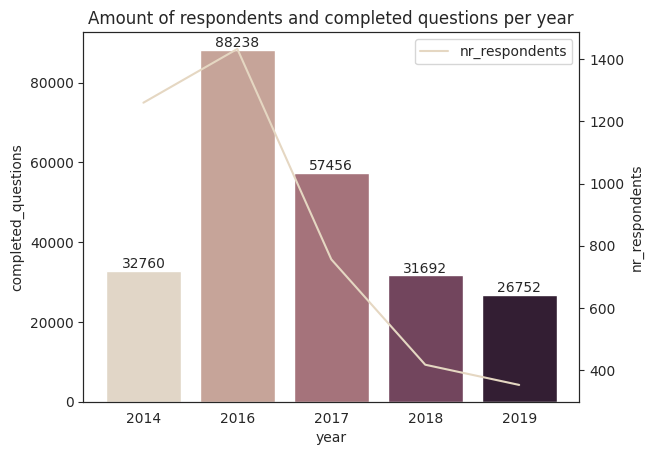

In [ ]:
ax = sns.barplot(
    x=merged_year.index, y=merged_year["completed_questions"], palette="ch:.25"
)
ax2 = ax.twinx()
sns.lineplot(
    x=merged_year.index, y=merged_year["nr_respondents"], ax=ax2, label="nr_respondents"
)
ax.set_ylabel("completed_questions")
ax2.set_ylabel("nr_respondents")
plt.title("Amount of respondents and completed questions per year")
for i, v in enumerate(merged_year["completed_questions"]):
    ax.text(i, v + 1, str(v), ha="center", va="bottom", fontsize=10);

* 2016 was clearly the most succesful year in terms of data collection, as there were both most respondents and most answered questions.
* In 2017, there were much less respondents than in 2014, but looking at the amount of completed questions, much more data was collected in 2017. The survey consisted of nearly 3 times more questions in 2017.
* Thus, we could wonder what the ideal number of questions is, when the goal is to collect as much data as possible in terms of answered questions.


### Respondent Demographics
* What does our sample look like in terms of age, gender and country of residence?

#### Age

In [ ]:
query_age = """
SELECT
CAST(AnswerText AS INT) AS age
FROM Answer
WHERE QuestionID = 1 AND CAST(AnswerText AS int) > 17 AND CAST(AnswerText AS int) < 66
"""
age = pd.read_sql_query(query_age, connection)
age.describe()

,age
count,"4,195.00"
mean,33.80
std,7.94
min,18.00
25%,28.00
50%,33.00
75%,38.00
max,65.00


* Taken together for all years, the average age is 34. We might wonder how close our age distribution approximates a normal distribution, since the median and mean are almost equal.
* When filtering to include only 18 to 65 year olds, we notice the total amount of values is lower than the total of 4218 respondents. We have filtered out 23 cases who didn't fill out an age value between 18 and 65, leaving us with 4195 valid cases for age.
* We might wonder if these respondents only gave an invalid answer for age, or if their answers do not make sense throughout the whole questionnaire. We will check this for the first series of questions.

In [ ]:
invalids_query = """
SELECT
UserID,
UserID || '_' || SurveyID as userid_year,
QuestionID,
AnswerText
FROM Answer
WHERE QuestionID BETWEEN 1 AND 12
AND UserID IN (
SELECT UserID
FROM Answer
WHERE QuestionID = 1
AND (CAST(AnswerText AS int) < 18 OR CAST(AnswerText AS int) > 65))
GROUP BY 1,2,3
"""
invalids = pd.read_sql_query(invalids_query, connection)
invalids.pivot_table(
    values="AnswerText", index="userid_year", columns="QuestionID", aggfunc="sum"
)

QuestionID,1,2,3,4,5,6,7,8,9,10,11,12
userid_year,,,,,,,,,,,,
1091_2014,11,Male,United States,Ohio,1,No,0,1-5,1,No,Yes,No
1128_2014,-1,p,United States,Alabama,1,Yes,1,1-5,1,Yes,Yes,Yes
1183_2014,72,Female,United States,Indiana,0,Yes,1,500-1000,0,Yes,Don't know,No
1354_2016,17,Male,Brazil,-1,0,No,0,6-25,1,No,I don't know,Yes
144_2014,-29,Male,United States,Minnesota,0,No,0,More than 1000,0,Yes,Don't know,No
1633_2016,99,Other,United States of America,Michigan,0,Yes,1,6-25,1,Yes,Yes,Maybe
1825_2016,323,Male,United States of America,Oregon,0,Yes,0,100-500,1,Yes,I don't know,Maybe
1917_2016,3,Male,Canada,-1,0,I don't know,1,More than 1000,1,Yes,I don't know,No
1962_2016,66,Male,United States of America,Maine,0,Yes,1,6-25,0,No,I don't know,No


In [ ]:
query_question_head = "SELECT * FROM Question LIMIT 12"
question_head = pd.read_sql_query(
    query_question_head, connection, index_col="questionid"
)
question_head = question_head.style.set_properties(
    **{"text-align": "left"}, subset=pd.IndexSlice[:, :]
)
question_head

,questiontext
questionid,
1,What is your age?
2,What is your gender?
3,What country do you live in?
4,"If you live in the United States, which state or territory do you live in?"
5,Are you self-employed?
6,Do you have a family history of mental illness?
7,Have you ever sought treatment for a mental health disorder from a mental health professional?
8,How many employees does your company or organization have?
9,Is your employer primarily a tech company/organization?


* It seems like a lot of questions were closed-ended, seeing 0-1, Yes/No/Maybe, numerical ranges that seem categories, as answers.
* For some yes/no questions the answers come as 0/1 and for others as yes/no, which seems inconsistent.  
* With question 11 for example, there are answers "I don't know" and "Don't know", which doesn't make sense if this would have been a multiple choice question.
* We can see that some userid's most of the time used -1 as an answer, when seemingly irrelevant to the question, while the data was supposed to be cleaned already.

In conclusion, we cannot really be sure about some design aspects of the questionnaire, and in particular which questions were open vs closed-ended.

In [ ]:
invalids_query = """
SELECT
UserID,
SurveyID,
QuestionID,
AnswerText
FROM Answer
WHERE UserID IN (3447, 3449)
GROUP BY 1,2,3
"""
invalids = pd.read_sql_query(invalids_query, connection)
invalids.pivot_table(
    values="AnswerText", index="UserID", columns="QuestionID", aggfunc="sum"
)

QuestionID,1,2,3,4,5,6,7,8,9,10,...,80,81,82,83,84,85,86,87,88,89
UserID,,,,,,,,,,,,,,,,,,,,,
3447,-1,-1,-1,-1,1,Yes,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3449,-1,-1,-1,-1,1,Yes,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


Thus these cases are invalid and need to be filtered out.

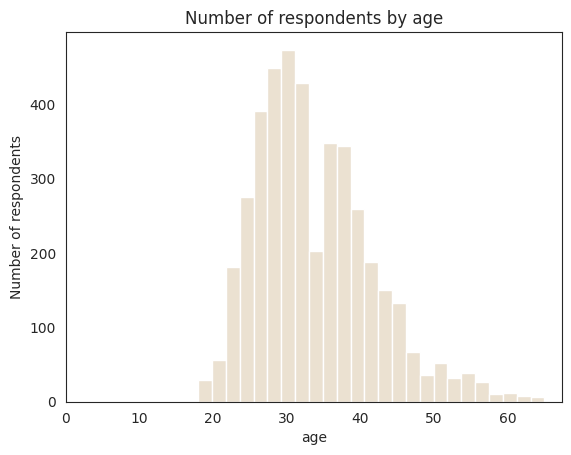

In [ ]:
ax = sns.histplot(x=age["age"], bins=25)
custom_x_ticks = range(0, 65, 10)
ax.set_xticks(custom_x_ticks)
ax.set_title("Number of respondents by age")
ax.set_ylabel("Number of respondents");

Taken together for all years, the age distribution is slightly right-skewed, we can see that by far most respondents are in their twenties and thirties, and much less in their 40s to 60s.


In [ ]:
query_agegroups = """
SELECT
SurveyID as year,
  CASE
    WHEN CAST(AnswerText AS int) < 20 THEN '< 20'
    WHEN CAST(AnswerText AS int) BETWEEN 20 and 29 THEN '20s'
    WHEN CAST(AnswerText AS int) BETWEEN 30 and 39 THEN '30s'
    WHEN CAST(AnswerText AS int) BETWEEN 40 and 49 THEN '40s'
    WHEN CAST(AnswerText AS int) BETWEEN 50 and 59 THEN '50s'
    ELSE '60s' END as agegroup,
  COUNT(DISTINCT UserID) AS nr_respondents
FROM Answer
WHERE QuestionID = 1 AND CAST(AnswerText AS int) > 17 AND CAST(AnswerText AS int) < 66
GROUP BY 1,2
ORDER BY 1,2
"""
agegroups = pd.read_sql_query(query_agegroups, connection)
age_grouped = agegroups.groupby("agegroup")[["nr_respondents"]].sum()
age_grouped["proportion"] = (
    age_grouped["nr_respondents"] / age_grouped["nr_respondents"].sum()
)
age_grouped

,nr_respondents,proportion
agegroup,,
20s,1352,0.32
30s,1932,0.46
40s,695,0.17
50s,161,0.04
60s,26,0.01
< 20,29,0.01


In [ ]:
query_avg_age = """
SELECT
  SurveyID as year,
  COUNT(DISTINCT UserID) AS respondents,
  CAST(AVG(AnswerText) AS int) as average_age
FROM Answer
WHERE QuestionID = 1
GROUP BY 1
"""
age_avg = pd.read_sql_query(query_avg_age, connection, index_col="year")
age_avg

,respondents,average_age
year,,
2014,1260,32
2016,1433,34
2017,756,34
2018,417,34
2019,352,35


Average age of the respondents seems to go up slightly over the years.

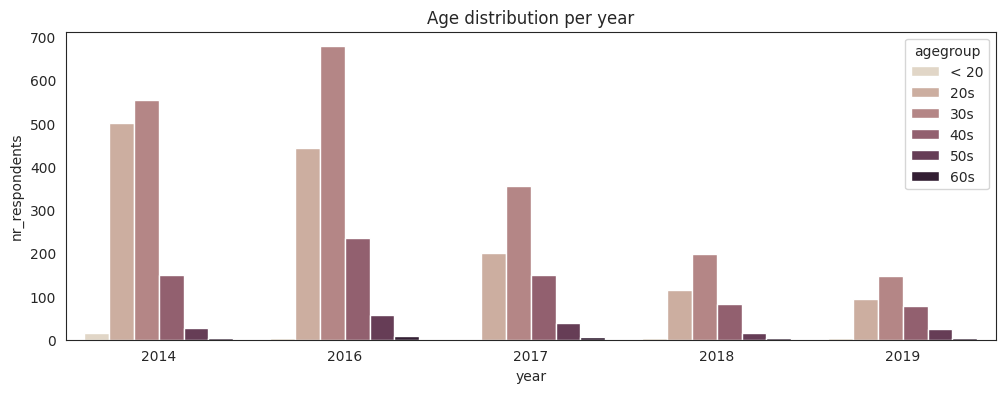

In [ ]:
plt.figure(figsize=(12, 4))
agegroup_order = ["< 20", "20s", "30s", "40s", "50s", "60s"]
sns.barplot(
    x=agegroups["year"],
    y=agegroups["nr_respondents"],
    hue=agegroups["agegroup"],
    hue_order=agegroup_order,
)
plt.title("Age distribution per year");

Age distribution does not differ much over the years. Each year, the largest group of respondents is in their 30's, followed by 20's, followed by 40's.

#### Gender

In [ ]:
gender_check = """
SELECT DISTINCT AnswerText,
COUNT(UserID) as nr_respondents
FROM Answer
WHERE QuestionID = 2
GROUP BY 1
ORDER BY 2 DESC
"""
gender_explore = pd.read_sql_query(gender_check, connection)
gender_explore

,AnswerText,nr_respondents
0,Male,2830
1,Female,914
2,male,212
3,female,110
4,-1,24
...,...,...
96,Agender/genderfluid,1
97,Agender trans woman,1
98,AFAB,1
99,A little about you,1


In [ ]:
query_gender = """
SELECT SurveyID as year,
CASE
WHEN AnswerText in ('Male', 'male') THEN 'male'
WHEN AnswerText in ('Female', 'female') THEN 'female'
ELSE 'other' END AS gender,
COUNT(UserID) as nr_respondents
FROM Answer
WHERE QuestionID = 2
GROUP BY 1,2
"""
gender = pd.read_sql_query(query_gender, connection)
gender.groupby("gender")[["nr_respondents"]].sum()

,nr_respondents
gender,
female,1024
male,3042
other,152


* There seem to be 101 different answers to the question which gender a person is. Since this could be a sensitive question which people might not want to answer, we will not consider any cases as suspicious with regard to the validity of the rest of their answers.
* It becomes clear that there are many more male than female respondents. Next, we wonder whether this changed over the years.

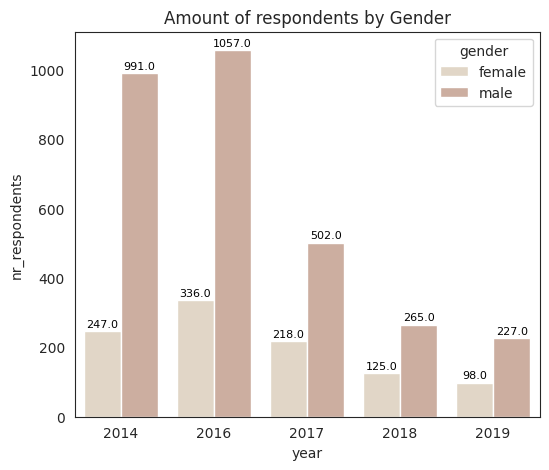

In [ ]:
plt.figure(figsize=(6, 5))
gender_filtered = gender[gender["gender"] != "other"]
ax = sns.barplot(
    x=gender_filtered["year"],
    y=gender_filtered["nr_respondents"],
    hue=gender_filtered["gender"],
)
ax.set_title("Amount of respondents by Gender")
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+p.get_width()/2., p.get_height()),
    ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
    textcoords='offset points'
)

We can see that each year, there were far more men than women amongst respondents. The gap seems to become slightly smaller over the years though, with women only making up about one third of the sample in the first 2 years, and a little less than half in the last 3 years.

#### Country

In [ ]:
query_country = """
SELECT
SurveyID as year,
AnswerText as country,
COUNT(AnswerText) as nr_respondents
FROM Answer
WHERE QuestionID = 3
group by 1,2

"""
country = pd.read_sql_query(query_country, connection)
country["country"] = country["country"].replace(
    {"United States of America": "United States"}
)
country_grouped = (
    country.groupby("country")[["nr_respondents"]]
    .sum()
    .sort_values("nr_respondents", ascending=False)
)
country_grouped["proportion"] = (
    country_grouped["nr_respondents"] / country_grouped["nr_respondents"].sum()
)
country_top10 = country_grouped.head(10)
country_top10

,nr_respondents,proportion
country,,
United States,2604,0.62
United Kingdom,482,0.11
Canada,199,0.05
Germany,136,0.03
Netherlands,98,0.02
Australia,73,0.02
Ireland,51,0.01
France,51,0.01
India,50,0.01


Checking for any irregular values, we only two times find a value of -1 for country. However, these belong to the 2 cases filtered above.  

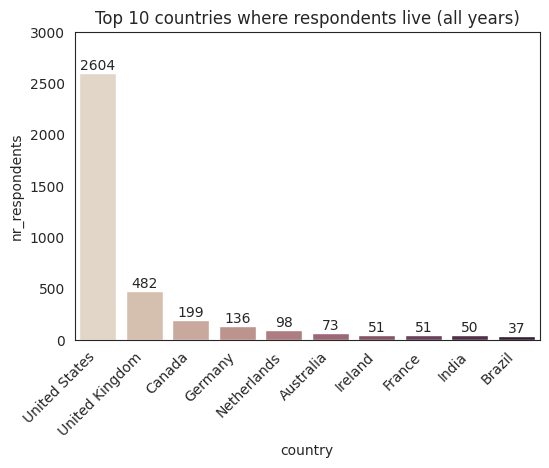

In [ ]:
plt.figure(figsize=(6, 4))
ax = sns.barplot(
    x=country_top10.index, y=country_top10["nr_respondents"], palette="ch:.25"
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
ax.set_title("Top 10 countries where respondents live (all years)")
ax.set_ylim(0, 3000)
for i, v in enumerate(country_top10["nr_respondents"]):
    ax.text(i, v + 1, str(v), ha="center", va="bottom", fontsize=10);

Looking at the data of all years together, there are respondents in 80 different countries. Recalling there were 4218 respondents in total, the US clearly is the country where the majority of respondents is residing.  
We might wonder if every year there were respondents in 80 different countries or if this differs per year.  

In [ ]:
country.groupby("year")[["country"]].nunique().rename(columns={"country":"countries"})

,countries
year,
2014,48
2016,53
2017,45
2018,41
2019,32


We can see that per year, the amount of countries where respondents were based is going down over the years, which is not unexpected as the total amount of respondents goes down over the years too.  

In [ ]:
grouped_year = country.sort_values(
    by=["year", "nr_respondents"], ascending=[True, False]
)
top5_peryear = grouped_year.groupby("year").head(5)

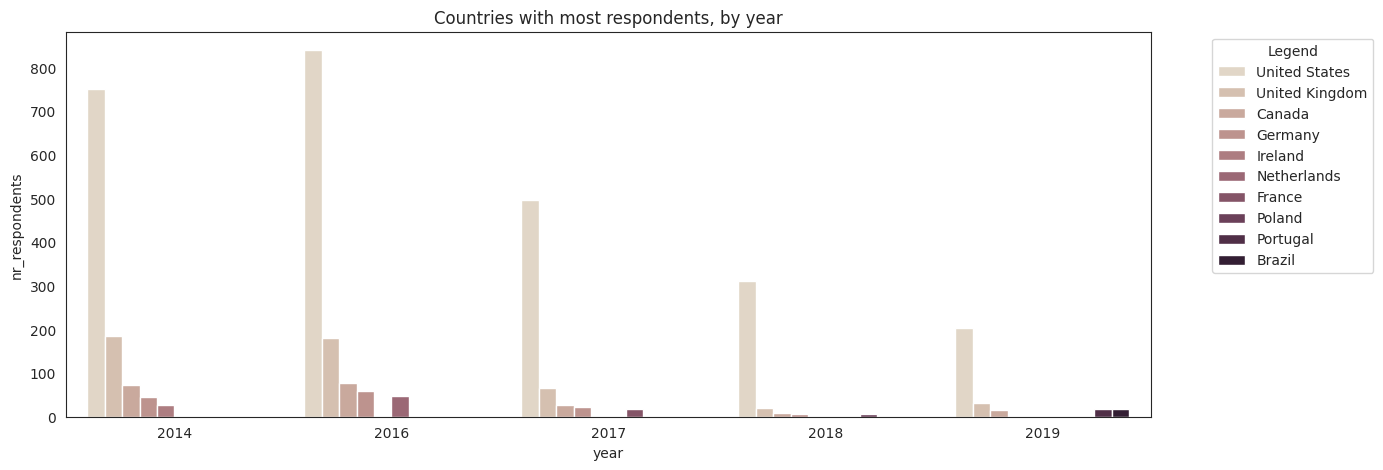

In [ ]:
plt.figure(figsize=(14, 5))
ax = sns.barplot(
    x=top5_peryear["year"],
    y=top5_peryear["nr_respondents"],
    hue=top5_peryear["country"],
    palette="ch:.25",
)
ax.set_title("Countries with most respondents, by year")
plt.legend(title="Legend", bbox_to_anchor=(1.05, 1), loc="upper left");

It looks like the three countries that were most represented were the same each year: US, UK, and Canada. Germany consistently is fourth, except for the last year.
From the variation of countries in the legend, we can see that for the rest it varied quite a bit where respondents came from.
Note that this graph only represents the top5 for each year. Countries outside the top 5 above have in most cases less than 10 respondents.   

### Questionnaire composition
* How much does the set of questions overlap between years?
* Which questions were asked in all years?

In [ ]:
answer.groupby("year")[["questionid"]].nunique().rename(
    columns={"questionid": "nr_of_questions"}
)

,nr_of_questions
year,
2014,26
2016,60
2017,76
2018,76
2019,76


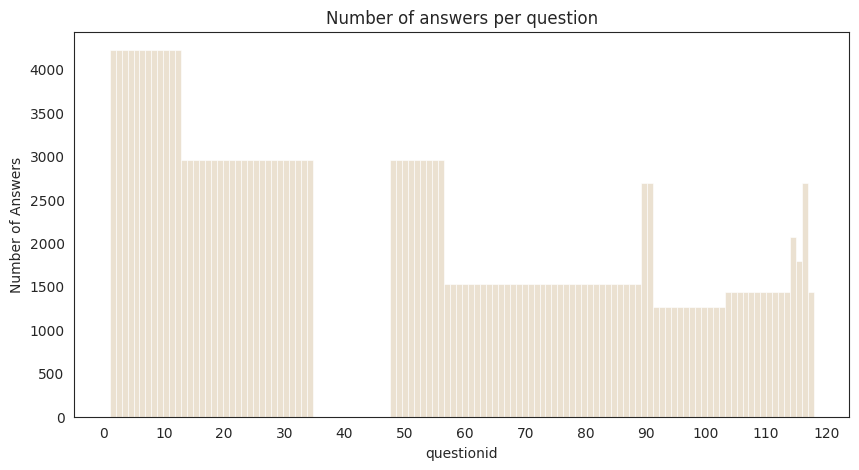

In [ ]:
plt.figure(figsize=(10, 5))
ax = sns.histplot(x=answer["questionid"], bins=118)
custom_x_ticks = range(0, 130, 10)
ax.set_xticks(custom_x_ticks)
ax.set_title("Number of answers per question")
ax.set_ylabel("Number of Answers");

* We can see that a couple of questions has been taken out of the survey around question number 40, which explains the higher max questionid, compared to the total unique amount of questions.
* It seems like the first questions were filled out over 4000 times, thus we can conclude these were included all years.
* There seems to be a clear drop at about question number 10, another just before 60 and then a few ups and downs.



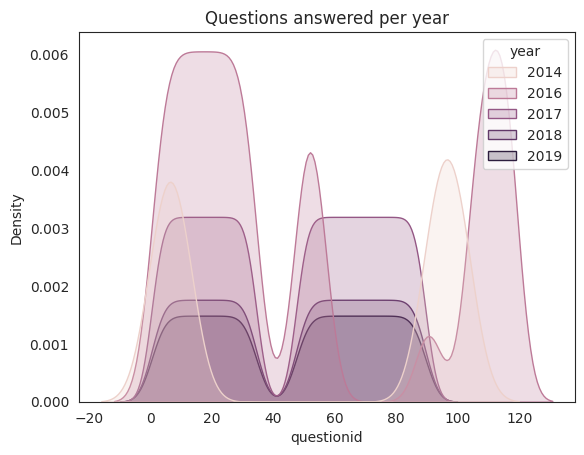

In [ ]:
sns.kdeplot(data=answer, x="questionid", hue="year", fill=True)
plt.title("Questions answered per year");

* Looking at the overlap between different years, we notice that the questionnaire was the same in 2017, 2018 and 2019.
* 2016 seems to largely overlap with those 3 years, except between question number 60 and 90.
* The questionid's after 90 are partly shared and partly unique to 2014 and 2016.

From this, we might wonder which questions have been always included in the survey.

In [ ]:
shared_questions = """
SELECT questionid, questiontext
FROM Question
WHERE questionid IN (
SELECT questionid
FROM Answer
GROUP BY questionid
HAVING COUNT(DISTINCT SurveyID) = 5)
"""
questions = pd.read_sql_query(shared_questions, connection, index_col="questionid")
questions

,questiontext
questionid,
1,What is your age?
2,What is your gender?
3,What country do you live in?
4,"If you live in the United States, which state or territory do you live in?"
5,Are you self-employed?
6,Do you have a family history of mental illness?
7,Have you ever sought treatment for a mental health disorder from a mental health professional?
8,How many employees does your company or organization have?
9,Is your employer primarily a tech company/organization?


* It turns out only the first 12 questions have been present in the survey each year, thus we have limited data if we want to do year-over-year comparison for all years.
* For example, based on question 10, we could investigate whether the proportion of employers that provides mental health benefits as part of healthcare coverage, changed over the years. We could add a third variable and investigate whether this differs between tech vs non-tech companies, and for age, gender or country.
* However, if we decide not to take into account 2014, there are more overlapping questions to choose from.

## Part 3: Statistical Analysis

#### Gender differences in searching treatment

In [ ]:
query_mental_treatment = """
WITH gender AS (
SELECT
UserID,
SurveyID AS year,
CASE
WHEN AnswerText = 'Female' THEN 1
WHEN AnswerText = 'Male' THEN 0 END AS gender
FROM Answer
WHERE QuestionID = 2 AND AnswerText in ('Female', 'Male'))
SELECT
year,
gender,
AnswerText as treatment_sought
FROM gender g
JOIN Answer a
on a.UserID = g.UserID
WHERE a.QuestionID = 7
"""
treatment = pd.read_sql_query(query_mental_treatment, connection)
treatment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3744 entries, 0 to 3743
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   year              3744 non-null   int64 
 1   gender            3744 non-null   int64 
 2   treatment_sought  3744 non-null   object
dtypes: int64(2), object(1)
memory usage: 87.9+ KB


In [ ]:
treatment["treatment_sought"] = treatment["treatment_sought"].astype(int)

In [ ]:
treatment.groupby(["year", "gender"])[["gender"]].count()

gender
year gender        
2014 0          991
     1          247
2016 0         1057
     1          336
2017 0          400
     1          155
2018 0          207
     1          105
2019 0          175
     1           71

In [ ]:
treatment.groupby("gender")[["gender"]].count()

,gender
gender,
0,2830
1,914


In [ ]:
stats_test_data = treatment.groupby("gender")["treatment_sought"].agg([np.mean, np.var, np.std])
stats_test_data

,mean,var,std
gender,,,
0,0.51,0.25,0.50
1,0.73,0.20,0.44


In [ ]:
men = treatment[treatment["gender"]==0]["treatment_sought"].sample(n=914, random_state=22)
women = treatment[treatment["gender"]==1]["treatment_sought"]

In [ ]:
men.agg([np.mean, np.var, np.std])

mean   0.49
var    0.25
std    0.50
Name: treatment_sought, dtype: float64

In [ ]:
import statsmodels.api as sm
from scipy import stats
alpha = 0.05
t_stat, p_value = stats.ttest_ind(women, men, equal_var=False, alternative="greater")
std_error = np.sqrt(np.var(women, ddof=1) / len(women) + np.var(men, ddof=1) / len(men))
df = len(women) + len(men) - 2
mean_difference = np.mean(women) - np.mean(men)
conf_int = stats.t.interval(0.95, df, loc=mean_difference, scale=std_error)
print(f'Difference in Means: {mean_difference:.4f}')
print(f"Confidence Interval for the Difference in Means: ({conf_int[0]:.4f}, {conf_int[1]:.4f})\n")
print(f't-statistic: {t_stat:.2f}')
print(f'p-value: {p_value:.4f}\n')

Difference in Means: 0.2429
Confidence Interval for the Difference in Means: (0.1995, 0.2863)

t-statistic: 10.98
p-value: 0.0000



Now we wonder if there is a difference between years in the overall proportion (regardless of gender) of respondents that sought mental treatment.

In [ ]:
treatment.groupby("year")["treatment_sought"].agg([np.mean, np.var, np.std])

,mean,var,std
year,,,
2014,0.50,0.25,0.50
2016,0.58,0.24,0.49
2017,0.61,0.24,0.49
2018,0.64,0.23,0.48
2019,0.64,0.23,0.48


In [ ]:
year_test_data = treatment[["year","treatment_sought"]]

Now we can do an Anova to investigate this.

In [ ]:
import statsmodels.formula.api as smf
model = smf.ols('year ~ treatment_sought', data=year_test_data).fit()

aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
treatment_sought,1.00,86.90,86.90,36.96,0.00
Residual,"3,742.00","8,798.64",2.35,NaN,NaN


## Part 4: Conclusions

* The questionnaire was held for 5 years between 2014 and 2019. The first year it only existed of 26 questions, while in later years it consisted of many more questions, either 60 or 76.
* The questions differed especially in the first 2 years, the last 3 years the survey remained exactly the same. Only 12 out of 105 questions have been included in each year, however if not taking the first year into account, there was much more overlap.
* Completion rates did not differ between years. However, incompletes might have been filtered out already.
* In terms of data collection, a larger number of questions did not necessarily lead to a larger amount of total answered questions. However, since our completion rates were 100% each year, this is due to a smaller sample of respondents for years in which the questionnaire was longer. However, we don't know which sampling decisions were made so it could have been on purpose that less participants were recruited in later years.

In terms of respondent demographics:
* The average age was 34, not differing much between years, with the majority of respondents (>70%) in their 30s and 20s.
* The majority of respondents is male, about 75%, this is also not differing much between years.
* Each year, respondents in about 30-50 different countries participated. However, the majority of respondents, over 50%, is residing in the US. Followed by UK and Canada, together accounting for the far majority of respondents.

It seems like no stratified sampling based on demographic variables was done, as the numbers on the variables above seem pretty unbalanced.

## Part 5: Limitations

We lack a lot of information about the design of the questionnaire, and sample collection: probability vs non-probability, which would have been vital in order to know which statistical tests we could run, and do a proper analysis over the answers.
* In a normal setup you will likely have both the questions and the answer options, which are open/closed-ended, which answer options are binary and which have more options, in order to know which answers are valid and which aren't.
* There is no information about decisions on sampling. For example, was the number of respondents needed, decided on beforehand and the survey only sent out to specific respondent candidates in order to meet requirements of random sampling? Or was it just handed out to anyone who was willing to fill it in?  